In [1]:
# Autoreload changed python modules
%load_ext autoreload

In [2]:
import os, glob
import h5py # for loading .h5 files
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
plt.style.use('seaborn') # pretty matplotlib plots
plt.rcParams["axes.grid"] = False # don't show grid lines on plots by default
plt.rcParams['figure.figsize'] = (12, 16) # increase size of subplots

In [4]:
import cs230_project_utilities as utils
# make sure you have pywt: pip3 install PyWavelets --user

# Loading the data

In [5]:
# Location of directory H5Exports_AnimiX/ (downloaded from Olivier's link)
DATASET_DIRECTORY = '/home/ubuntu/cs230/data/H5Exports_AnimiX'

In [6]:
# Find all the files in our dataset
h5_files = utils.automap.find_dataset_files(DATASET_DIRECTORY)

Found 134 .h5 files and 134 .txt files.


# Visualizing the data

In [7]:
##### Finally, we can see the raw data
sample_filename = list(h5_files.keys())[20]
print('Taking a look at file: {}'.format(sample_filename))
h5 = h5_files[sample_filename]['h5']
h5_data = utils.automap.read_h5_file(h5)
print(h5_data.keys())

images = h5_data['images']
magnitude = h5_data['magnitude']
phase = h5_data['phase']
classification = h5_data['classification']

# (Note: shape of magnitude and phase are different from image)
print(images.shape, magnitude.shape, phase.shape)
print(np.ndarray.flatten(classification))

Taking a look at file: 943_10158
dict_keys(['classification', 'images', 'magnitude', 'phase'])
(15, 256, 256) (15, 256, 256) (15, 256, 256)
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [8]:
sample_index = np.argmax(classification)

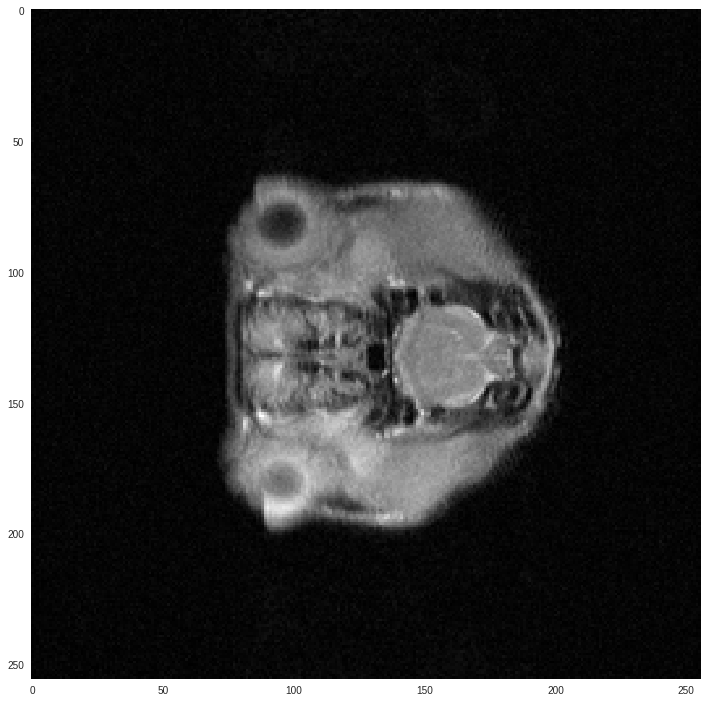

In [9]:
# Uncomment to view example image in dataset
utils.plot.imshowgray(images[sample_index])

In [10]:
# Construct FFT (k-space data) from magnitude and phase
fft = magnitude[sample_index] * np.exp(1j * phase[sample_index])

# Take the inverse FFT
ifft = utils.signal_processing.ifft_2D_centered(fft)

# Note: shape of magnitude and phase are different from image.
# Because of this, the reconstruction shape is different from the
# image shape and so we can't compare the image and reconstruction directly.
# How will we solve this?

# This check to make sure we are correctly combining magnitude and phase to construct the full, complex-valued FFT.
print('Error in FFT magnitude: {}'.format(utils.signal_processing.mean_square_error(np.abs(fft), magnitude[sample_index])))
print('Error in FFT phase: {}'.format(utils.signal_processing.mean_square_error(np.angle(fft), phase[sample_index])))

Error in FFT magnitude: 2.4687782802584184e-20
Error in FFT phase: 5.288901564141631e-16


/home/ubuntu/cs230/code/MRI_reconstruction_example/cs230_project_utilities/plot.py:13: RuntimeWarning: divide by zero encountered in log10
  imshowgray(20 * np.log10(np.abs(fft)))


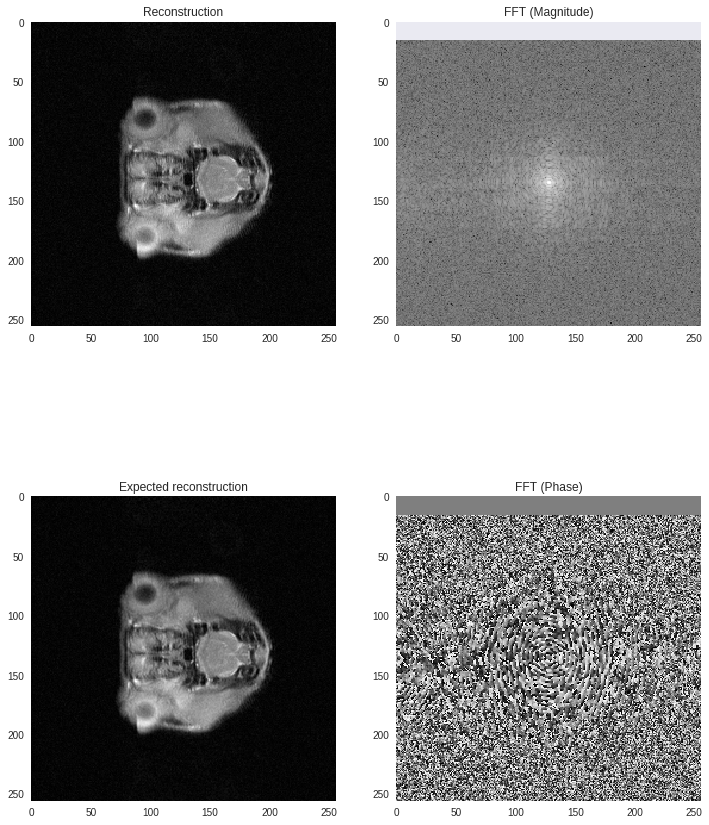

In [11]:
''' Uncomment to show plots.'''
plt.subplot(2, 2, 1)
plt.title('Reconstruction')
utils.plot.imshowgray(np.abs(ifft))
# 
plt.subplot(2, 2, 2)
plt.title('FFT (Magnitude)')
utils.plot.imshowfft(np.abs(fft))

plt.subplot(2, 2, 3)
plt.title('Expected reconstruction')
image = images[sample_index]
utils.plot.imshowgray(image)

plt.subplot(2, 2, 4)
plt.title('FFT (Phase)')
utils.plot.imshowgray(np.angle(fft))

# Automap Model

In [12]:
import tensorflow as tf

In [13]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

In [14]:
import keras
from keras.layers import Input,Conv2D, Conv2DTranspose, Dense, Reshape, Flatten
from keras.models import Model
from keras.optimizers import RMSprop
from keras import losses

Using TensorFlow backend.


In [15]:
tf.reset_default_graph()

# NEW

In [ ]:
# Ref: https://github.com/tetianadadakova/MRI-CNN/blob/master/myAutomap.py

import numpy as np
import tensorflow as tf
from tensorflow.python.framework import ops
import math
import time
from generate_input import load_images_from_folder


# Load training data:
tic1 = time.time()
dir_train = 'path to the folder with images for training'  # Folder with images
n_im = 10000  # How many images to load
X_train, Y_train = load_images_from_folder(  # Load images for training
    dir_train,
    n_im,
    normalize=False,
    imrotate=True)
toc1 = time.time()
print('Time to load data = ', (toc1 - tic1))
print('X_train.shape at input = ', X_train.shape)
print('Y_train.shape at input = ', Y_train.shape)


def create_placeholders(n_H0, n_W0):
    """ Creates placeholders for x and y for tf.session
    :param n_H0: image height
    :param n_W0: image width
    :return: x and y - tf placeholders
    """

    x = tf.placeholder(tf.float32, shape=[None, n_H0, n_W0, 2], name='x')
    y = tf.placeholder(tf.float32, shape=[None, n_H0, n_W0], name='y')

    return x, y


def initialize_parameters():
    """ Initializes filters for the convolutional and de-convolutional layers
    :return: parameters - a dictionary of filters (W1 - first convolutional
    layer, W2 - second convolutional layer, W3 - de-convolutional layer
    """

    W1 = tf.get_variable("W1", [5, 5, 1, 64],  # 64 filters of size 5x5
                         initializer=tf.contrib.layers.xavier_initializer
                         (seed=0))
    W2 = tf.get_variable("W2", [5, 5, 64, 64],  # 64 filters of size 5x5
                         initializer=tf.contrib.layers.xavier_initializer
                         (seed=0))
    W3 = tf.get_variable("W3", [7, 7, 1, 64],  # 64 filters of size 7x7
                         initializer=tf.contrib.layers.xavier_initializer
                         (seed=0))  # conv2d_transpose

    parameters = {"W1": W1,
                  "W2": W2,
                  "W3": W3}

    return parameters


def forward_propagation(x, parameters):
    """ Defines all layers for forward propagation:
    Fully connected (FC1) -> tanh activation: size (n_im, n_H0 * n_W0)
    -> Fully connected (FC2) -> tanh activation:  size (n_im, n_H0 * n_W0)
    -> Convolutional -> ReLU activation: size (n_im, n_H0, n_W0, 64)
    -> Convolutional -> ReLU activation with l1 regularization: size (n_im, n_H0, n_W0, 64)
    -> De-convolutional: size (n_im, n_H0, n_W0)
    :param x: Input - images in frequency space, size (n_im, n_H0, n_W0, 2)
    :param parameters: parameters of the layers (e.g. filters)
    :return: output of the last layer of the neural network
    """

    x_temp = tf.contrib.layers.flatten(x)  # size (n_im, n_H0 * n_W0 * 2)
    n_out = np.int(x.shape[1] * x.shape[2])  # size (n_im, n_H0 * n_W0)

    with tf.device('/gpu:0'):
        # FC: input size (n_im, n_H0 * n_W0 * 2), output size (n_im, n_H0 * n_W0)
        FC1 = tf.contrib.layers.fully_connected(
            x_temp,
            n_out,
            activation_fn=tf.tanh,
            normalizer_fn=None,
            normalizer_params=None,
            weights_initializer=tf.contrib.layers.xavier_initializer(),
            weights_regularizer=None,
            biases_initializer=None,
            biases_regularizer=None,
            reuse=tf.AUTO_REUSE,
            variables_collections=None,
            outputs_collections=None,
            trainable=True,
            scope='fc1')

    with tf.device('/cpu:0'):
        # FC: input size (n_im, n_H0 * n_W0), output size (n_im, n_H0 * n_W0)
        FC2 = tf.contrib.layers.fully_connected(
            FC1,
            n_out,
            activation_fn=tf.tanh,
            normalizer_fn=None,
            normalizer_params=None,
            weights_initializer=tf.contrib.layers.xavier_initializer(),
            weights_regularizer=None,
            biases_initializer=None,
            biases_regularizer=None,
            reuse=tf.AUTO_REUSE,
            variables_collections=None,
            outputs_collections=None,
            trainable=True,
            scope='fc2')

    # Reshape output from FC layers into array of size (n_im, n_H0, n_W0, 1):
    FC_M = tf.reshape(FC2, [tf.shape(x)[0], tf.shape(x)[1], tf.shape(x)[2], 1])

    # Retrieve the parameters from the dictionary "parameters":
    W1 = parameters['W1']
    W2 = parameters['W2']
    W3 = parameters['W3']

    # CONV2D: filters W1, stride of 1, padding 'SAME'
    # Input size (n_im, n_H0, n_W0, 1), output size (n_im, n_H0, n_W0, 64)
    Z1 = tf.nn.conv2d(FC_M, W1, strides=[1, 1, 1, 1], padding='SAME')
    # RELU
    CONV1 = tf.nn.relu(Z1)

    # CONV2D: filters W2, stride 1, padding 'SAME'
    # Input size (n_im, n_H0, n_W0, 64), output size (n_im, n_H0, n_W0, 64)
    # Z2 = tf.nn.conv2d(CONV1, W2, strides=[1, 1, 1, 1], padding='SAME')
    # RELU
    # CONV2 = tf.nn.relu(Z2)
    CONV2 = tf.layers.conv2d(
        CONV1,
        filters=64,
        kernel_size=5,
        strides=(1, 1),
        padding='same',
        data_format='channels_last',
        dilation_rate=(1, 1),
        activation=tf.nn.relu,
        use_bias=True,
        kernel_initializer=None,
        bias_initializer=tf.zeros_initializer(),
        kernel_regularizer=tf.contrib.layers.l1_regularizer(0.0001),
        bias_regularizer=None,
        activity_regularizer=None,
        kernel_constraint=None,
        bias_constraint=None,
        trainable=True,
        name='conv2',
        reuse=tf.AUTO_REUSE)

    # DE-CONV2D: filters W3, stride 1, padding 'SAME'
    # Input size (n_im, n_H0, n_W0, 64), output size (n_im, n_H0, n_W0, 1)
    batch_size = tf.shape(x)[0]
    deconv_shape = tf.stack([batch_size, x.shape[1], x.shape[2], 1])
    DECONV = tf.nn.conv2d_transpose(CONV2, W3, output_shape=deconv_shape,
                                    strides=[1, 1, 1, 1], padding='SAME')
    DECONV = tf.squeeze(DECONV)

    return DECONV


def compute_cost(DECONV, Y):
    """
    Computes cost (squared loss) between the output of forward propagation and
    the label image
    :param DECONV: output of forward propagation
    :param Y: label image
    :return: cost (squared loss)
    """

    cost = tf.square(DECONV - Y)

    return cost


def random_mini_batches(x, y, mini_batch_size=64, seed=0):
    """ Shuffles training examples and partitions them into mini-batches
    to speed up the gradient descent
    :param x: input frequency space data
    :param y: input image space data
    :param mini_batch_size: mini-batch size
    :param seed: can be chosen to keep the random choice consistent
    :return: a mini-batch of size mini_batch_size of training examples
    """

    m = x.shape[0]  # number of input images
    mini_batches = []
    np.random.seed(seed)

    # Shuffle (x, y)
    permutation = list(np.random.permutation(m))
    shuffled_X = x[permutation, :]
    shuffled_Y = y[permutation, :]

    # Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = int(math.floor(
        m / mini_batch_size))  # number of mini batches of size mini_batch_size

    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size:k * mini_batch_size
                                    + mini_batch_size, :, :, :]
        mini_batch_Y = shuffled_Y[k * mini_batch_size:k * mini_batch_size
                                    + mini_batch_size, :, :]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches
                                  * mini_batch_size: m, :, :, :]
        mini_batch_Y = shuffled_Y[num_complete_minibatches
                                  * mini_batch_size: m, :, :]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    return mini_batches


def model(X_train, Y_train, learning_rate=0.0001,
          num_epochs=100, minibatch_size=64, print_cost=True):
    """ Runs the forward and backward propagation
    :param X_train: input training frequency-space data
    :param Y_train: input training image-space data
    :param learning_rate: learning rate of gradient descent
    :param num_epochs: number of epochs
    :param minibatch_size: size of mini-batch
    :param print_cost: if True - the cost will be printed every epoch, as well
    as how long it took to run the epoch
    :return: this function saves the model to a file. The model can then
    be used to reconstruct the image from frequency space
    """

    with tf.device('/gpu:0'):
        ops.reset_default_graph()  # to not overwrite tf variables
        seed = 3
        (m, n_H0, n_W0, _) = X_train.shape

        # Create Placeholders
        X, Y = create_placeholders(n_H0, n_W0)

        # Initialize parameters
        parameters = initialize_parameters()

        # Build the forward propagation in the tf graph
        DECONV = forward_propagation(X, parameters)

        # Add cost function to tf graph
        cost = compute_cost(DECONV, Y)

        # Backpropagation
        optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(cost)

        # Initialize all the variables globally
        init = tf.global_variables_initializer()

        # Add ops to save and restore all the variables
        saver = tf.train.Saver()

        # For memory
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True

        # Memory config
        #config = tf.ConfigProto()
        #config.gpu_options.allow_growth = True
        config = tf.ConfigProto(log_device_placement=True)

        # Start the session to compute the tf graph
        with tf.Session(config=config) as sess:

            # Initialization
            sess.run(init)

            # Training loop
            for epoch in range(num_epochs):
                tic = time.time()

                minibatch_cost = 0.
                num_minibatches = int(m / minibatch_size)  # number of minibatches
                seed += 1
                minibatches = random_mini_batches(X_train, Y_train,
                                                  minibatch_size, seed)
                # Minibatch loop
                for minibatch in minibatches:
                    # Select a minibatch
                    (minibatch_X, minibatch_Y) = minibatch
                    # Run the session to execute the optimizer and the cost
                    _, temp_cost = sess.run(
                        [optimizer, cost],
                        feed_dict={X: minibatch_X, Y: minibatch_Y})

                    cost_mean = np.mean(temp_cost) / num_minibatches
                    minibatch_cost += cost_mean

                # Print the cost every epoch
                if print_cost:
                    toc = time.time()
                    print ('EPOCH = ', epoch, 'COST = ', minibatch_cost, 'Elapsed time = ', (toc - tic))

            # Save the variables to disk.
            save_path = saver.save(sess, "path to save model/model_name.ckpt")
            print("Model saved in file: %s" % save_path)

            sess.close()


# Finally run the model!
model(X_train, Y_train,
      learning_rate=0.00002,
      num_epochs=30,
      minibatch_size=64,  # should be < than the number of input examples
      print_cost=True)

